In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage,  fcluster
from sklearn.metrics import silhouette_score
import datetime as dt
import numpy as np

# Read the CSV file
grouped2 = pd.read_csv('../../processed_data/Second_dataset/New_dataset_Merchant_corresponding_incomes.csv')

In [3]:
grouped2

,Third Party Name,Account No,Balance,Amount,Datetime,Transaction Type
0,a cut above,104832000.0,-2441.204859,-200.00,2023-08-08 15:37:00,Income
1,a yarn story,969804197.0,814.130000,-43.96,2023-01-01 12:19:00,Income
2,a yarn story,441142605.0,1182.262700,-7.98,2023-01-02 09:38:00,Income
3,a yarn story,687135796.0,1059.382100,-26.97,2023-01-04 11:15:00,Income
4,a yarn story,263882093.0,439.691500,-38.50,2023-01-04 15:17:00,Income
...,...,...,...,...,...,...
215348,xbox,331450202.0,9706.489072,-7.00,2023-11-30 23:59:00,Income
215349,xbox,575652395.0,2192.938098,-7.00,2023-11-30 23:59:00,Income
215350,xbox,574548998.0,237.865050,-7.00,2023-11-30 23:59:00,Income
215351,xbox,586041848.0,2880.694700,-7.00,2023-11-30 23:59:00,Income


In [5]:
grouped2['Datetime'] = pd.to_datetime(grouped2['Datetime'])
current_date = grouped2['Datetime'].max()

rfm = grouped2.groupby(['Third Party Name', 'Account No']).agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'Account No': 'count',                                        # Frequency
    'Amount': lambda x: -x.sum()                                    # Monetary
}).rename(columns={
    'Datetime': 'recency',
    'Account No': 'frequency',
    'Amount': 'monetary'
}).reset_index()

In [6]:
rfm = rfm.groupby('Third Party Name').filter(lambda x: len(x) > 2 and x[['recency', 'frequency', 'monetary']].std().sum() > 0)

rfm_labels_df = pd.DataFrame()
best_ks = []

for third_party_name in rfm['Third Party Name'].unique():
    account_rfm = rfm[rfm['Third Party Name'] == third_party_name]
    
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])
    
    linked = linkage(rfm_scaled, method='ward')
    
    # Ensure sufficient data points for multiple cluster analysis
    if len(account_rfm) > 1:
        silhouette_scores = []
        max_clusters = min(len(account_rfm), 10)  # The maximum number of clusters is 10 or the number of samples
        for k in range(2, max_clusters + 1):
            labels = fcluster(linked, k, criterion='maxclust')
            if len(set(labels)) > 1:  # Ensure that there are more than one category
                score = silhouette_score(rfm_scaled, labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(-1)

        if silhouette_scores:
            best_k = np.argmax(silhouette_scores) + 2
            print(f"Best number of clusters for {third_party_name}: {best_k}")
            best_ks.append(best_k)

            final_labels = fcluster(linked, best_k, criterion='maxclust')
            account_rfm['Cluster'] = final_labels
            account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
            rfm_labels_df = pd.concat([rfm_labels_df, account_rfm], ignore_index=True)
    else:
        print(f"Not enough data for clustering in {third_party_name}")

print(rfm_labels_df.head())

Best number of clusters for a yarn story: 10
Best number of clusters for amazon: 3
Best number of clusters for blackwell's: 4
Best number of clusters for blizzard: 2
Best number of clusters for boots: 3


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for brilliant brushes: 2
Best number of clusters for cass art: 2
Best number of clusters for cex: 2
Best number of clusters for coffee #1: 2
Best number of clusters for collector cave: 2
Best number of clusters for coop local: 2
Best number of clusters for costa coffee: 3
Best number of clusters for craftastic: 4
Best number of clusters for deliveroo: 2
Best number of clusters for disney: 4


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for etsy: 2
Best number of clusters for fat face: 3
Best number of clusters for fitted stitch: 3
Best number of clusters for five senses art: 3
Best number of clusters for foyles: 2
Best number of clusters for gamestation: 2
Best number of clusters for grand union bjj: 3


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for halifax: 2
Best number of clusters for hobby lobby: 2
Best number of clusters for hobbycraft: 2
Best number of clusters for jd sports: 4
Best number of clusters for justeat: 2
Best number of clusters for kew house: 2
Best number of clusters for kings arms: 3
Best number of clusters for lavender primary: 2
Best number of clusters for lbg: 2
Best number of clusters for lloyds pharmacy: 3
Best number of clusters for loosely fitted: 3
Best number of clusters for mamas & papas: 2


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for matalan: 2
Best number of clusters for mojang studios: 10
Best number of clusters for netflix: 5
Best number of clusters for puregym: 4


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for reebok: 4
Best number of clusters for revella: 4
Best number of clusters for rose & crown: 4
Best number of clusters for sainsbury: 2
Best number of clusters for sainsbury local: 2
Best number of clusters for selfridges: 3


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for sports direct: 4
Best number of clusters for squareonix: 10
Best number of clusters for starbucks: 3
Best number of clusters for stitch by stitch: 2
Best number of clusters for tesco: 2
Best number of clusters for the crown: 6


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for the works: 2
Best number of clusters for topshop: 3
Best number of clusters for wool: 3
Best number of clusters for xbox: 3
  Third Party Name   Account No  recency  frequency  monetary  Cluster  \
0     a yarn story  128033695.0       16         15    292.60        8   
1     a yarn story  138969884.0      158          1     47.84        1   
2     a yarn story  221868392.0      319          1      2.99        2   
3     a yarn story  228136274.0      281          1     33.00        2   
4     a yarn story  235881534.0      319          1    134.85        2   

  Cluster_Label  
0       Label_8  
1       Label_1  
2       Label_2  
3       Label_2  
4       Label_2  


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

In [7]:
median_k = np.median(best_ks)
mode_k = pd.Series(best_ks).mode()[0]
mean_k = np.mean(best_ks)
print(median_k,mode_k,mean_k)

3.0 2 3.185185185185185


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  centers = {i: account_rfm[account_labels == i].mean(axis=0) for i in centers_indices}
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  centers = {i: account_rfm[account_labels == i].mean(axis=0) for i in centers_indices}
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The defa

  Third Party Name   Account No  recency  frequency  monetary  Cluster  \
0     a yarn story  128033695.0       16         15    292.60        3   
1     a yarn story  138969884.0      158          1     47.84        1   
2     a yarn story  221868392.0      319          1      2.99        1   
3     a yarn story  228136274.0      281          1     33.00        1   
4     a yarn story  235881534.0      319          1    134.85        1   

               Cluster_Label  
0       Developing Customers  
1  Low-Value/Risky Customers  
2  Low-Value/Risky Customers  
3  Low-Value/Risky Customers  
4  Low-Value/Risky Customers  


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  centers = {i: account_rfm[account_labels == i].mean(axis=0) for i in centers_indices}
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  centers = {i: account_rfm[account_labels == i].mean(axis=0) for i in centers_indices}
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_64649/2096106044.py:20: FutureWarning: The defa

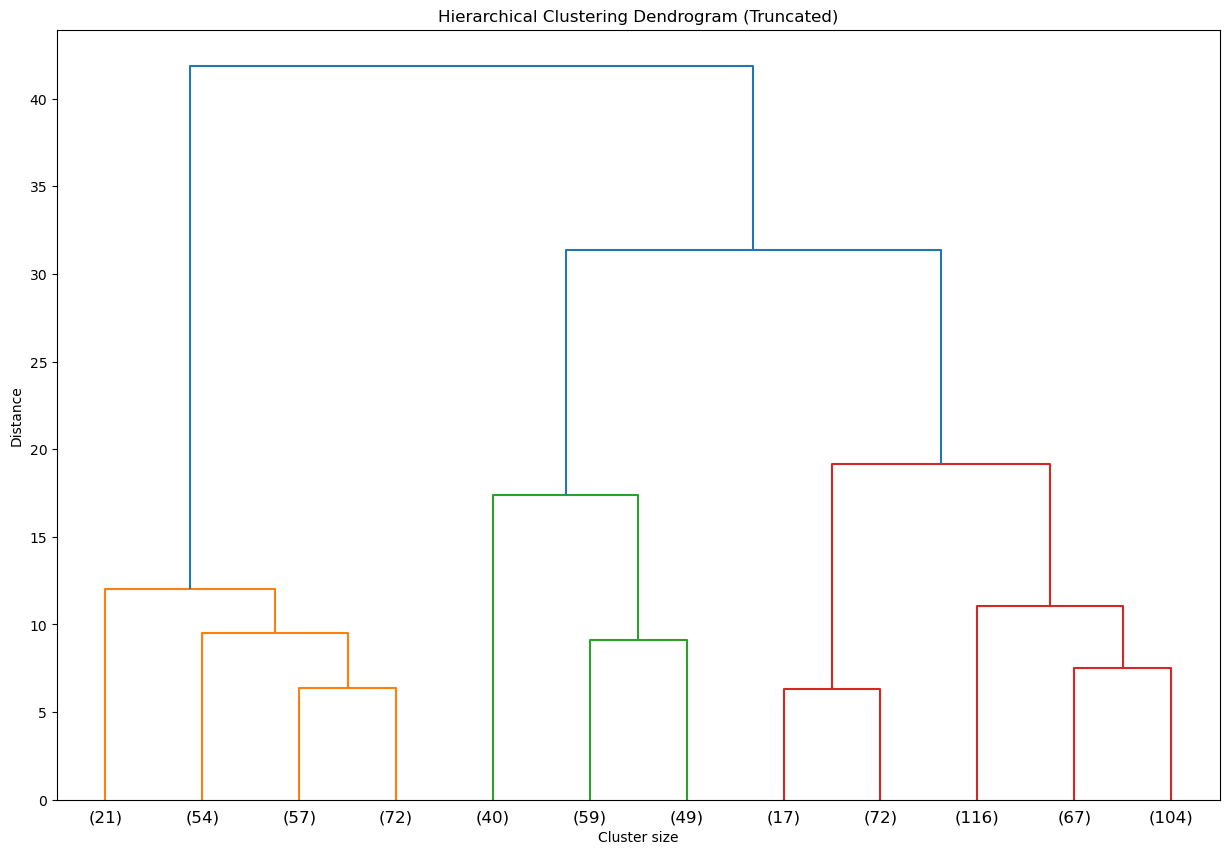

In [14]:
rfm_labels_results = pd.DataFrame()
# Cluster customers separately for each merchant
for third_party_name in rfm['Third Party Name'].unique():
    account_rfm = rfm[rfm['Third Party Name'] == third_party_name]
    
    # Standardization of current merchant data
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])
    
    linked = linkage(rfm_scaled, method='ward')
    global_k = 3  
    account_labels = fcluster(linked, global_k, criterion='maxclust')
    
    # Identify features of each cluster and assign customer type labels
    centers_indices = range(1, global_k+1)
    centers = {i: account_rfm[account_labels == i].mean(axis=0) for i in centers_indices}
    
    # Sort Clustering Centers by Monetary Features
    sorted_centers = sorted(centers, key=lambda k: centers[k]['monetary'], reverse=True)
    
    # Distribution labels
    cluster_labels = {}
    for i, center_idx in enumerate(sorted_centers, start=1):
        if i == 1:
            cluster_labels[center_idx] = 'High-Value Customers'
        elif i == 2:
            cluster_labels[center_idx] = 'Developing Customers'
        else:
            cluster_labels[center_idx] = 'Low-Value/Risky Customers'
    
    account_rfm['Cluster'] = account_labels
    account_rfm['Cluster_Label'] = account_rfm['Cluster'].map(cluster_labels)
    
    # Merge the current merchant's clustering results into the total DataFrame
    rfm_labels_results = pd.concat([rfm_labels_results, account_rfm], axis=0, ignore_index=True)

print(rfm_labels_results.head())

# Visualization Tree Diagram
plt.figure(figsize=(15, 10))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


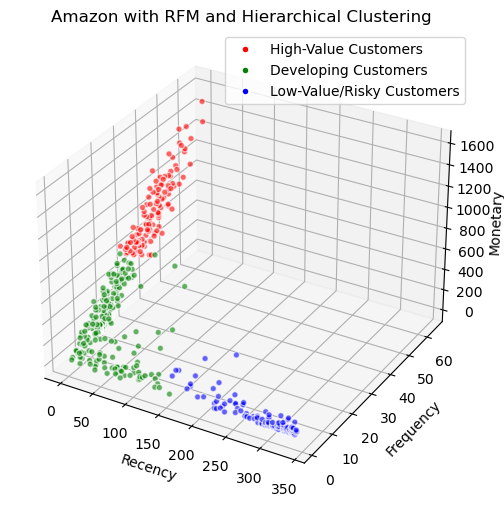

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

account_rfm = rfm[rfm['Third Party Name'] == rfm['Third Party Name'].unique()[1]]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])
rfm_original = scaler.inverse_transform(rfm_scaled)
    
linked = linkage(rfm_scaled, method='ward')


global_k = 3  
account_clusters = fcluster(linked, global_k, criterion='maxclust')

new_clusters = []
for cluster in account_clusters:
    if cluster == 1:
        new_clusters.append(0)
    if cluster == 2:
        new_clusters.append(2)    
    if cluster == 3:
        new_clusters.append(1)

set_colors = ['red', 'green', 'blue']
set_labels = ['High-Value Customers', 'Developing Customers', 'Low-Value/Risky Customers']    
    
colors = [set_colors[label] for label in new_clusters]
    
#Create a new graph and a 3D subgraph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


#Assign data points to three-dimensional space
xs = rfm_original[:, 0]  # Recency
ys = rfm_original[:, 1]  # Frequency
zs = rfm_original[:, 2]  # Monetary


#Create a 3D scatter plot with colors defined by clustering labels
scatter = ax.scatter(xs, ys, zs, c=colors, marker='o', alpha=0.6, edgecolors='w')


 #Set chart titles and axis labels
ax.set_title('Amazon with RFM and Hierarchical Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary', labelpad=1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                         markerfacecolor=color, markersize=5) for color, label in zip(set_colors, set_labels)]
ax.legend(handles=legend_elements, loc='best')

plt.show()

In [18]:
rfm_labels_results.to_csv('rfm-results.csv', index=False)

In [14]:
print(f'The Silhouette score of hierarchical clustering is {silhouette_score(rfm_scaled, account_clusters)}')

The Silhouette score of hierarchical clustering is 0.6730828000341295
